<font size="+3"><strong>Assignment: Predicting Apartment Prices in Mexico City 🇲🇽</strong></font>

Import libraries here

In [4]:
from glob import glob

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px 
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

# Prepare Data

## Import

**Task 2.5.1:** (8 points) Write a `wrangle` function that takes the name of a CSV file as input and returns a DataFrame. The function should do the following steps:<br>
<br>
1. Subset the data in the CSV file and return only apartments in Mexico City (`"Distrito Federal"`) that cost less than \$100,000.<br>
2. Remove outliers by trimming the bottom and top 10\% of properties in terms of `"surface_covered_in_m2"`.<br>
3. Create separate `"lat"` and `"lon"` columns.<br>
4. Mexico City is divided into [16 boroughs](https://en.wikipedia.org/wiki/Boroughs_of_Mexico_City). Create a `"borough"` feature from the `"place_with_parent_names"` column.<br>
5. Drop columns that are more than 50\% null values.<br>
6. Drop columns containing low- or high-cardinality categorical values. <br>
7. Drop any columns that would constitute leakage for the target `"price_aprox_usd"`.<br>
8. Drop any columns that would create issues of multicollinearity. <br>
<br>
<div class="alert alert-block alert-info"><br>
<b>Tip:</b> Don't try to satisfy all the criteria in the first version of your <code>wrangle</code> function. Instead, work iteratively. Start with the first criteria, test it out with one of the Mexico CSV files in the <code>data/</code> directory, and submit it to the grader for feedback. Then add the next criteria.</div>

In [7]:
df = pd.read_csv('/Users/lau_pang/Desktop/WorldQuant/project2/mexico-city-real-estate-1.csv')
df.head()

,Unnamed: 0,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
0,1,sell,apartment,|Miguel Hidalgo|Distrito Federal|México|,"23.634501,-102.552788",5500000.0,MXN,5450245.50,289775.66,NaN,54.0,NaN,101851.851900,NaN,NaN,NaN,http://miguel-hidalgo-df.properati.com.mx/o3zb...
1,2,sell,house,|Iztapalapa|Distrito Federal|México|,"19.31033,-99.068557",1512000.0,MXN,1498321.97,79661.96,NaN,80.0,NaN,18900.000000,NaN,NaN,NaN,http://iztapalapa.properati.com.mx/q7t0_venta_...
2,3,sell,apartment,|Tlalpan|Distrito Federal|México|,"19.279771,-99.234597",926667.0,MXN,918284.00,48822.82,NaN,100.0,NaN,9266.670000,NaN,NaN,NaN,http://tlalpan.properati.com.mx/qbi4_venta_dep...
3,4,sell,apartment,|Miguel Hidalgo|Distrito Federal|México|,"23.634501,-102.552788",6410000.0,MXN,6352013.39,337720.36,NaN,135.0,NaN,47481.481480,NaN,NaN,NaN,http://miguel-hidalgo-df.properati.com.mx/opeq...
4,5,sell,apartment,|Benito Juárez|Quintana Roo|México|,"21.1902642,-86.8198375",875000.0,USD,16457437.50,875000.00,0.0,263.0,NaN,3326.996198,NaN,NaN,NaN,http://cancun.properati.com.mx/hg4t_venta_depa...


Build your `wrangle` function

In [8]:
def wrangle(filepath):
    df = pd.read_csv(filepath)
    #subset to apartments that is in Mexico City and costs less than 100,000
    condition1 = df['property_type'] == 'apartment'
    condition2 = df['place_with_parent_names'].str.contains('Distrito Federal')
    condition3 = df['price_aprox_usd'] < 100000
    df = df[condition1 & condition2 & condition3]
    
    # remove outliers 
    low, high = df['surface_covered_in_m2'].quantile([0.1, 0.9])
    condition4 = df['surface_covered_in_m2'].between(low, high)
    df = df[condition4]
    
    # split 'lat-lon' column
    df[['lat', 'lon']] = df['lat-lon'].str.split(',', expand = True).astype(float)
    df.drop(columns = 'lat-lon', inplace = True)
    
    # extract the boroughs from 'place_with_parent_names' columns
    df['borough'] = df['place_with_parent_names'].str.split('|', expand = True)[1]
    df.drop(columns = 'place_with_parent_names', inplace = True)
    
    # drop columns with more than 50% null values
    df.drop(columns = ['surface_total_in_m2', 'price_usd_per_m2', 'floor', 'rooms', 'expenses'],
           inplace = True)
    
    # drop low- and high-cardinality columns
    df.drop(columns = ['operation', 'property_type', 'currency', 'properati_url'],
           inplace = True)
    
    # drop leaky columns
    df.drop(columns = ['price', 'price_aprox_local_currency', 'price_per_m2'], inplace = True)
    
    return df

Use this cell to test your wrangle function and explore the data

In [9]:
df = wrangle('/Users/lau_pang/Desktop/WorldQuant/project2/mexico-city-real-estate-1.csv')
df.head()

,Unnamed: 0,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
11,12,94022.66,57.0,23.634501,-102.552788,Benito Juárez
20,21,70880.12,56.0,19.402413,-99.095391,Iztacalco
21,22,68228.99,80.0,19.357820,-99.149406,Benito Juárez
22,23,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
26,27,94140.20,50.0,19.354219,-99.126244,Coyoacán


**Task 2.5.2:** Use glob to create the list `files`. It should contain the filenames of all the Mexico City real estate CSVs in the `./data` directory, except for `mexico-city-test-features.csv`.

In [10]:
files = glob('/Users/lau_pang/Desktop/WorldQuant/project2/mexico-city-real-estate-*.csv')
files

['/Users/lau_pang/Desktop/WorldQuant/project2/mexico-city-real-estate-5.csv',
 '/Users/lau_pang/Desktop/WorldQuant/project2/mexico-city-real-estate-4.csv',
 '/Users/lau_pang/Desktop/WorldQuant/project2/mexico-city-real-estate-1.csv',
 '/Users/lau_pang/Desktop/WorldQuant/project2/mexico-city-real-estate-3.csv',
 '/Users/lau_pang/Desktop/WorldQuant/project2/mexico-city-real-estate-2.csv']

**Task 2.5.3:** Combine your `wrangle` function, a list comprehension, and `pd.concat` to create a DataFrame `df`. It should contain all the properties from the five CSVs in `files`. 

In [11]:
df = [wrangle(file) for file in files]
df = pd.concat(df, ignore_index = True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5473 entries, 0 to 5472
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             5473 non-null   int64  
 1   price_aprox_usd        5473 non-null   float64
 2   surface_covered_in_m2  5473 non-null   float64
 3   lat                    5149 non-null   float64
 4   lon                    5149 non-null   float64
 5   borough                5473 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 256.7+ KB
None


,Unnamed: 0,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
0,2,82737.39,75.0,19.362690,-99.150565,Benito Juárez
1,4,72197.60,62.0,19.291345,-99.124312,Tlalpan
2,5,44277.72,85.0,19.354987,-99.061709,Iztapalapa
3,14,60589.45,52.0,19.469681,-99.086136,Gustavo A. Madero
4,19,47429.08,53.0,19.443592,-99.121407,Venustiano Carranza


## Explore

**Task 2.5.4:** Create a histogram showing the distribution of apartment prices (`"price_aprox_usd"`) in `df`. Be sure to label the x-axis `"Area [sq meters]"`, the y-axis `"Count"`, and give it the title `"Distribution of Apartment Prices"`.<br>
<br>
What does the distribution of price look like? Is the data normal, a little skewed, or very skewed?

Plot distribution of price

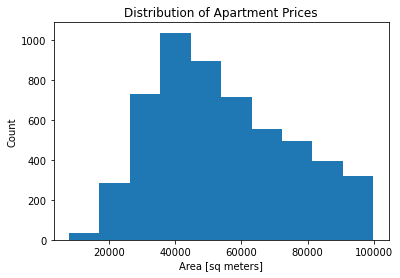

In [12]:
plt.hist(df['price_aprox_usd'])
plt.xlabel('Area [sq meters]')
plt.ylabel('Count')
plt.title('Distribution of Apartment Prices');

**Task 2.5.5:** Create a scatter plot that shows apartment price (`"price_aprox_usd"`) as a function of apartment size (`"surface_covered_in_m2"`). Be sure to label your axes `"Price [USD]"` and `"Area [sq meters]"`, respectively. Your plot should have the title `"Mexico City: Price vs. Area"`.<br>
<br>
Do you see a relationship between price and area in the data? How is this similar to or different from the Buenos Aires dataset?

Plot price vs area

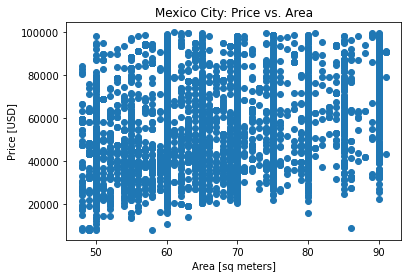

In [13]:
plt.scatter(x = df["surface_covered_in_m2"], y = df['price_aprox_usd'])
plt.xlabel('Area [sq meters]')
plt.ylabel('Price [USD]')
plt.title('Mexico City: Price vs. Area');

## Split

**Task 2.5.7:** Create your feature matrix `X_train` and target vector `y_train`. Your target is `"price_aprox_usd"`. Your features should be all the columns that remain in the DataFrame you cleaned above.

Split data into feature matrix `X_train` and target vector `y_train`.

In [14]:
target = 'price_aprox_usd'
features = ['surface_covered_in_m2', 'lat', 'lon', 'borough']

In [15]:
X_train = df[features]
y_train = df[target]

# Build Model

## Baseline

**Task 2.5.8:** Calculate the baseline mean absolute error for your model.

In [16]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print("Mean apt price:", y_mean)
print("Baseline MAE:", baseline_mae)

Mean apt price: 54246.53149826428
Baseline MAE: 17239.9394758883


## Iterate

**Task 2.5.9:** Create a pipeline named `model` that contains all the transformers necessary for this dataset and one of the predictors you've used during this project. Then fit your model to the training data.

Build Model

In [17]:
model = make_pipeline(
    OneHotEncoder(use_cat_names = True),
    SimpleImputer(),
    Ridge()
)
# Fit model
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['borough'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

## Evaluate

**Task 2.5.10:** Read the CSV file `mexico-city-test-features.csv` into the DataFrame `X_test`.

<div class="alert alert-block alert-info"><br>
<b>Tip:</b> Make sure the <code>X_train</code> you used to train your model has the same column order as <code>X_test</code>. Otherwise, it may hurt your model's performance.<br>
</div>

In [25]:
X_test = pd.read_csv('/Users/lau_pang/Desktop/WorldQuant/project2/mexico-city-test-features.csv')
X_test.drop(columns = 'Unnamed: 0', inplace =True)
print(X_test.info())
X_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surface_covered_in_m2  1041 non-null   int64  
 1   lat                    986 non-null    float64
 2   lon                    986 non-null    float64
 3   borough                1041 non-null   object 
dtypes: float64(2), int64(1), object(1)
memory usage: 32.7+ KB
None


,surface_covered_in_m2,lat,lon,borough
0,60,19.493185,-99.205755,Azcapotzalco
1,55,19.307247,-99.166700,Coyoacán
2,50,19.363469,-99.010141,Iztapalapa
3,60,19.474655,-99.189277,Azcapotzalco
4,74,19.394628,-99.143842,Benito Juárez


**Task 2.5.11:** Use your model to generate a Series of predictions for `X_test`. When you submit your predictions to the grader, it will calculate the mean absolute error for your model.

In [26]:
y_test_pred = pd.Series(model.predict(X_test))
y_test_pred.head()

0    53538.366480
1    53171.988369
2    34263.884179
3    53488.425607
4    68738.924884
dtype: float64

# Communicate Results

**Task 2.5.12:** Create a Series named `feat_imp`. The index should contain the names of all the features your model considers when making predictions; the values should be the coefficient values associated with each feature. The Series should be sorted ascending by absolute value.  

In [27]:
coefficients = model.named_steps['ridge'].coef_
features = model.named_steps['onehotencoder'].get_feature_names()
feat_imp = pd.Series(coefficients, index = features)
feat_imp

surface_covered_in_m2               291.654156
lat                                 478.901375
lon                               -2492.221814
borough_Benito Juárez             13778.188880
borough_Tlalpan                   10319.429804
borough_Iztapalapa               -13349.017448
borough_Gustavo A. Madero         -6637.429757
borough_Venustiano Carranza       -5609.918629
borough_Iztacalco                   405.403127
borough_Coyoacán                   3737.561001
borough_Cuauhtémoc                 -350.531990
borough_Miguel Hidalgo             1977.314718
borough_Azcapotzalco               2459.288646
borough_Tláhuac                  -14166.869486
borough_Álvaro Obregón             3275.121061
borough_La Magdalena Contreras    -5925.666450
borough_Xochimilco                  929.857400
borough_Cuajimalpa de Morelos      9157.269123
dtype: float64

**Task 2.5.13:** Create a horizontal bar chart that shows the **10 most influential** coefficients for your model. Be sure to label your x- and y-axis `"Importance [USD]"` and `"Feature"`, respectively, and give your chart the title `"Feature Importances for Apartment Price"`.

Create horizontal bar chart

Text(0.5, 1.0, 'Feature Importances for Apartment Price')

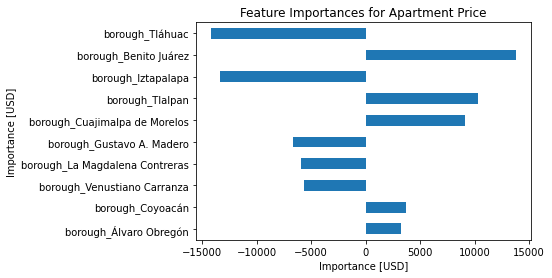

In [28]:
feat_imp.sort_values(key = abs).tail(10).plot(kind = 'barh')
plt.xlabel("Importance [USD]")
plt.ylabel("Importance [USD]")
plt.title('Feature Importances for Apartment Price')